In [28]:
import os
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='0'

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import random
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision

import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image


In [30]:
bs = 128

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

In [31]:
def train(epoch, device, weight):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var, weight)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [32]:
def test(device, weight):
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            recon, mu, log_var = vae(data)
            
            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var, weight).item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

# Task 1: Design the autoencoder structured network for MNIST

In [33]:
# YOUR CODE!!

class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        
        #############################################################
    
        # YOUR CODE!!
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc3_1 = nn.Linear(h_dim2, z_dim)
        self.fc3_2 = nn.Linear(h_dim2, z_dim)

        #############################################################
        
        
        # decoder part
        
        #############################################################
    
        # YOUR CODE!!
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        #############################################################
        
        
    def encoder(self, x):
        # return mu, log_var
        
        #############################################################
    
        # YOUR CODE!!
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc3_1(h), self.fc3_2(h) # mu, log_var
        #############################################################
    
    def sampling(self, mu, log_var):
        # return z sample
        
        #############################################################
    
        # YOUR CODE!!
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        #############################################################
        
    def decoder(self, z):
        # return generated img
        
        #############################################################
    
        # YOUR CODE!!
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h))
        #############################################################
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [35]:
vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=2)
if torch.cuda.is_available():
    vae.to(device)

In [36]:
vae

VAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3_1): Linear(in_features=256, out_features=2, bias=True)
  (fc3_2): Linear(in_features=256, out_features=2, bias=True)
  (fc4): Linear(in_features=2, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)

# Task 2: Design the loss function for autoencoder with weight of KLD term

In [37]:
optimizer = optim.Adam(vae.parameters())

In [38]:

def loss_function(recon_x, x, mu, log_var, weight):
    # return reconstruction error + weight*KL divergence losses
    
    #############################################################
    
    # YOUR CODE!!
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + weight*KLD
    #############################################################
    
    pass

In [39]:
from tqdm.autonotebook import tqdm

weight = 40.0
for epoch in tqdm(range(1, 51)):
    train(epoch, device, weight)
    test(device, weight)

Train Epoch: 1 [0/60000 (0%)]	Loss: 546.923096
Train Epoch: 1 [12800/60000 (21%)]	Loss: 212.112976
Train Epoch: 1 [25600/60000 (43%)]	Loss: 208.525772
Train Epoch: 1 [38400/60000 (64%)]	Loss: 201.179382
Train Epoch: 1 [51200/60000 (85%)]	Loss: 205.733215
====> Epoch: 1 Average loss: 212.3370
====> Test set loss: 206.4047
Train Epoch: 2 [0/60000 (0%)]	Loss: 207.441879
Train Epoch: 2 [12800/60000 (21%)]	Loss: 210.412323
Train Epoch: 2 [25600/60000 (43%)]	Loss: 204.689819
Train Epoch: 2 [38400/60000 (64%)]	Loss: 209.708344
Train Epoch: 2 [51200/60000 (85%)]	Loss: 209.638901
====> Epoch: 2 Average loss: 206.6132
====> Test set loss: 206.2888
Train Epoch: 3 [0/60000 (0%)]	Loss: 208.573486
Train Epoch: 3 [12800/60000 (21%)]	Loss: 199.041061
Train Epoch: 3 [25600/60000 (43%)]	Loss: 209.115250
Train Epoch: 3 [38400/60000 (64%)]	Loss: 206.768906
Train Epoch: 3 [51200/60000 (85%)]	Loss: 213.045532
====> Epoch: 3 Average loss: 206.5105
====> Test set loss: 206.1194
Train Epoch: 4 [0/60000 (0%)]	L

Train Epoch: 26 [12800/60000 (21%)]	Loss: 210.351898
Train Epoch: 26 [25600/60000 (43%)]	Loss: 209.661957
Train Epoch: 26 [38400/60000 (64%)]	Loss: 209.831238
Train Epoch: 26 [51200/60000 (85%)]	Loss: 203.567383
====> Epoch: 26 Average loss: 206.0943
====> Test set loss: 205.9074
Train Epoch: 27 [0/60000 (0%)]	Loss: 208.886246
Train Epoch: 27 [12800/60000 (21%)]	Loss: 206.096497
Train Epoch: 27 [25600/60000 (43%)]	Loss: 208.464996
Train Epoch: 27 [38400/60000 (64%)]	Loss: 204.224396
Train Epoch: 27 [51200/60000 (85%)]	Loss: 204.940018
====> Epoch: 27 Average loss: 206.0972
====> Test set loss: 205.8676
Train Epoch: 28 [0/60000 (0%)]	Loss: 209.223541
Train Epoch: 28 [12800/60000 (21%)]	Loss: 210.076492
Train Epoch: 28 [25600/60000 (43%)]	Loss: 206.220917
Train Epoch: 28 [38400/60000 (64%)]	Loss: 201.262909
Train Epoch: 28 [51200/60000 (85%)]	Loss: 209.362320
====> Epoch: 28 Average loss: 206.0908
====> Test set loss: 205.9103
Train Epoch: 29 [0/60000 (0%)]	Loss: 198.613861
Train Epoch: 

# Task 3

C:\Users\Trojan\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


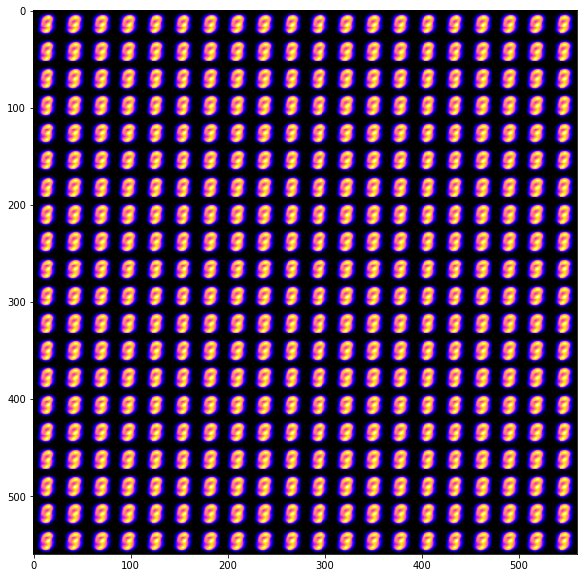

In [40]:
import matplotlib.pyplot as plt
from scipy.stats import norm

# Display a 2D manifold of the digits
n = 20  # figure with 20x20 digits
digit_size = 28
batch_size=128
figure = np.zeros((digit_size * n, digit_size * n))

# Construct grid of latent variable values
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

# decode for each square in the grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        z_sample = torch.tensor(z_sample).cpu()
        z_sample = torch.tensor(z_sample).to(device)
        sample = vae.decoder(z_sample.float()).detach().cpu()
        digit = sample[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

#save_image(sample, './samples/problem 3/weight_1' + '.png')

fig = plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gnuplot2')
plt.show()
fig.savefig('./samples/problem 3/weight_40' + '.png', bbox_inches='tight')

